In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/with_cloudy/train_B_over"
plot_title = "train_B_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.688515,0.689413,0.688520,0.689413,0.907237,0.907542,0.770476,0.770186,0.590172
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.811802,0.812343,0.811799,0.812343,0.938941,0.939364,0.850385,0.847239,0.750366
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.827681,0.827898,0.827684,0.827898,0.947063,0.947063,0.869777,0.864811,0.771117
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.833743,0.833919,0.833750,0.833919,0.951568,0.950784,0.880268,0.872570,0.779328
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.842893,0.842950,0.842899,0.842950,0.955695,0.955159,0.890358,0.882807,0.791017


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.740118,0.7290,0.641695,0.7290,0.903569,0.883003,0.775246,0.731615,0.557405
1,2,test,0.783422,0.7725,0.697043,0.7725,0.925545,0.917392,0.823428,0.795345,0.636776
2,3,test,0.807909,0.8005,0.731268,0.8005,0.939184,0.928637,0.852668,0.816065,0.672976
3,4,test,0.795621,0.7855,0.718276,0.7855,0.938272,0.932212,0.848967,0.821434,0.656848
4,5,test,0.817036,0.8095,0.740915,0.8095,0.945923,0.936588,0.866111,0.831341,0.685671


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/403:,Train,Loss,=,1.523,Valid,Loss,=,1.525,ETA,=,6.20h
1,Epoch,"1/40,",Batch,20/403:,Train,Loss,=,1.475,Valid,Loss,=,1.482,ETA,=,5.86h
2,Epoch,"1/40,",Batch,30/403:,Train,Loss,=,1.466,Valid,Loss,=,1.451,ETA,=,5.08h
3,Epoch,"1/40,",Batch,40/403:,Train,Loss,=,1.454,Valid,Loss,=,1.395,ETA,=,5.20h
4,Epoch,"1/40,",Batch,50/403:,Train,Loss,=,1.398,Valid,Loss,=,1.375,ETA,=,5.09h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.523,1.525
20,1,20,1.475,1.482
30,1,30,1.466,1.451
40,1,40,1.454,1.395
50,1,50,1.398,1.375


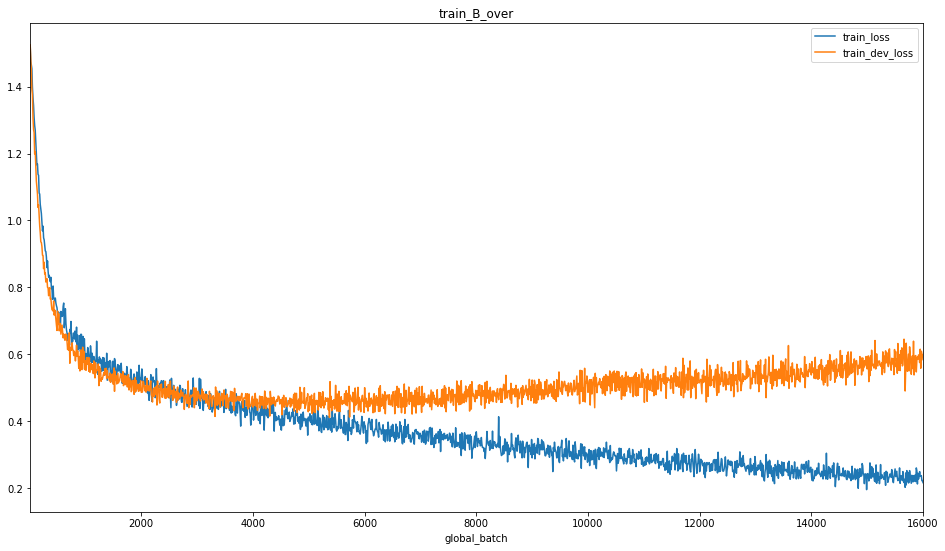

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.0270,0.9350
2,0.7055,0.6600
3,0.6055,0.5730
4,0.5675,0.5335
5,0.5265,0.5170


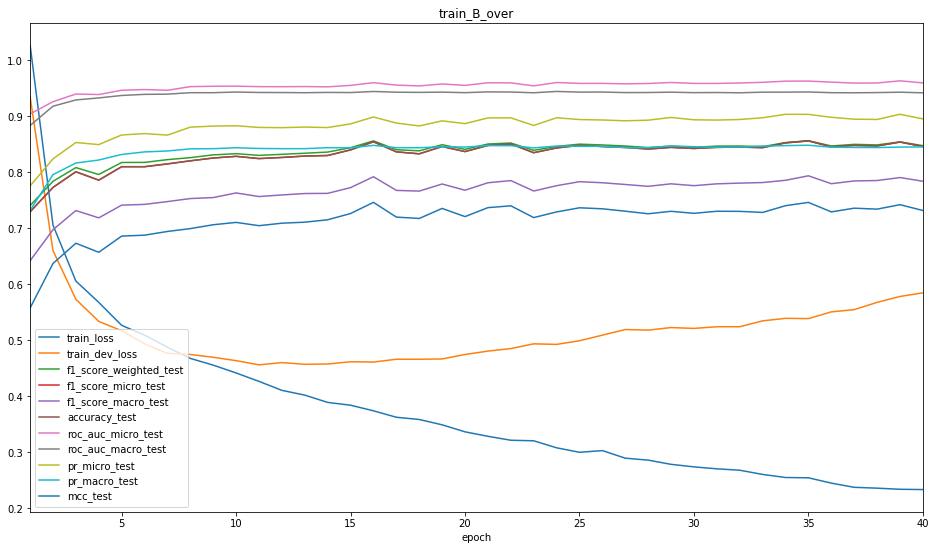

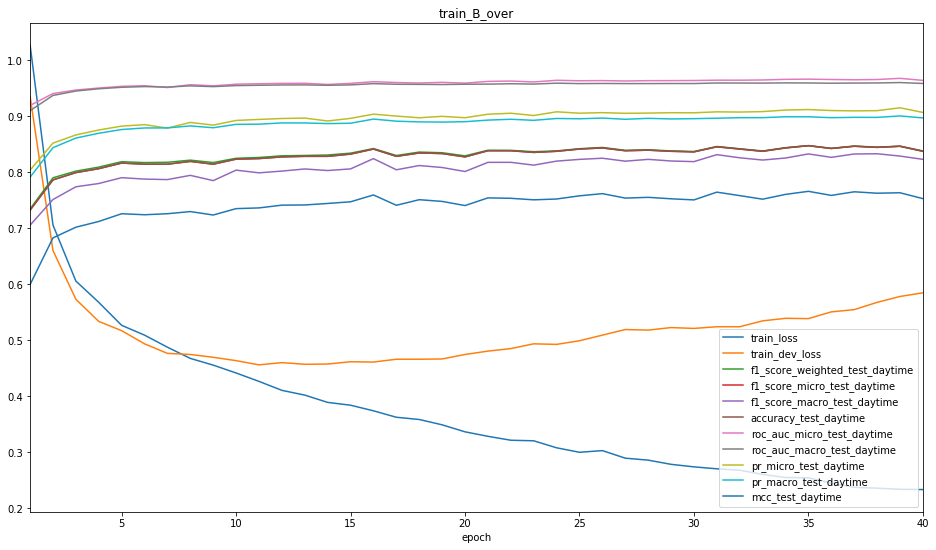

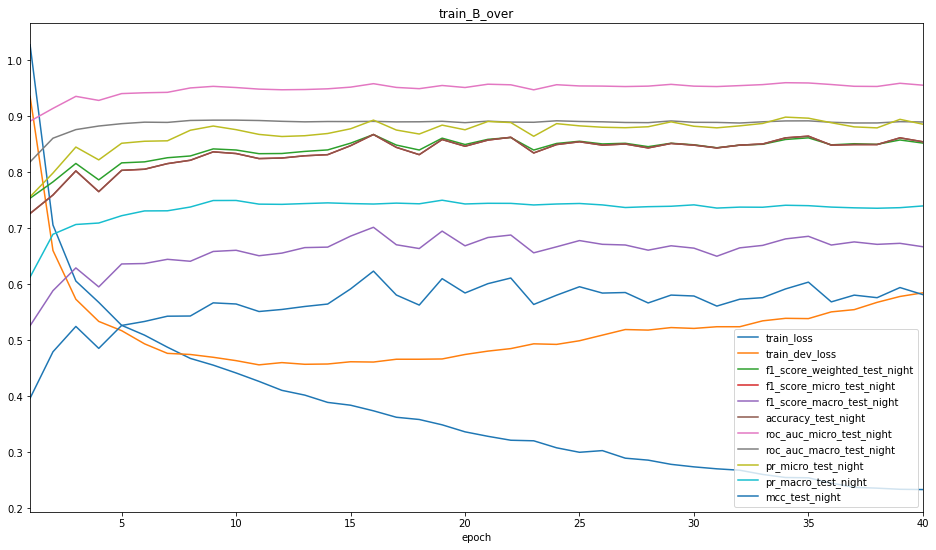

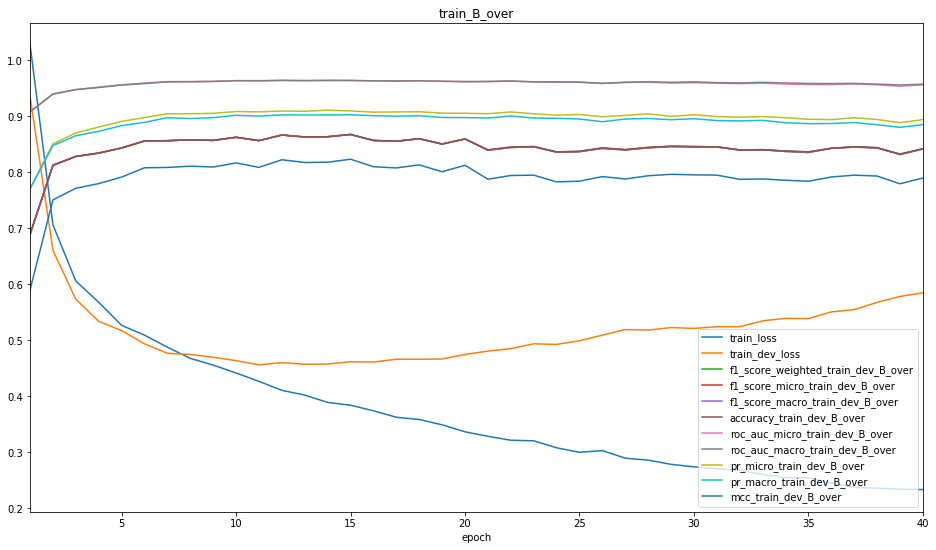

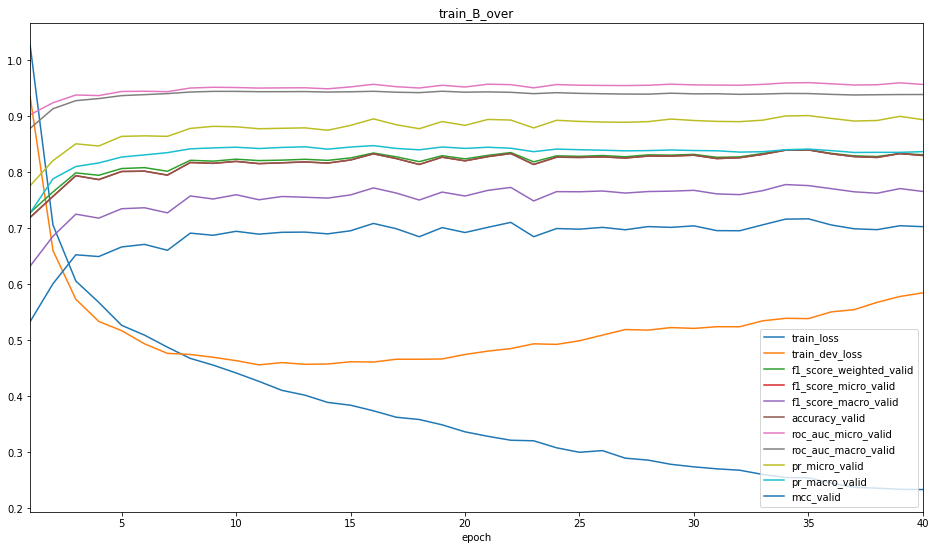

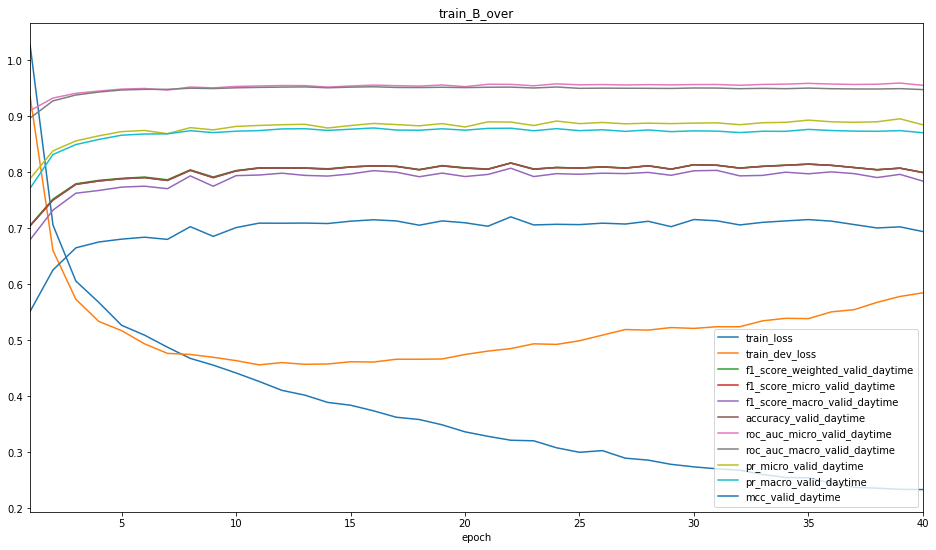

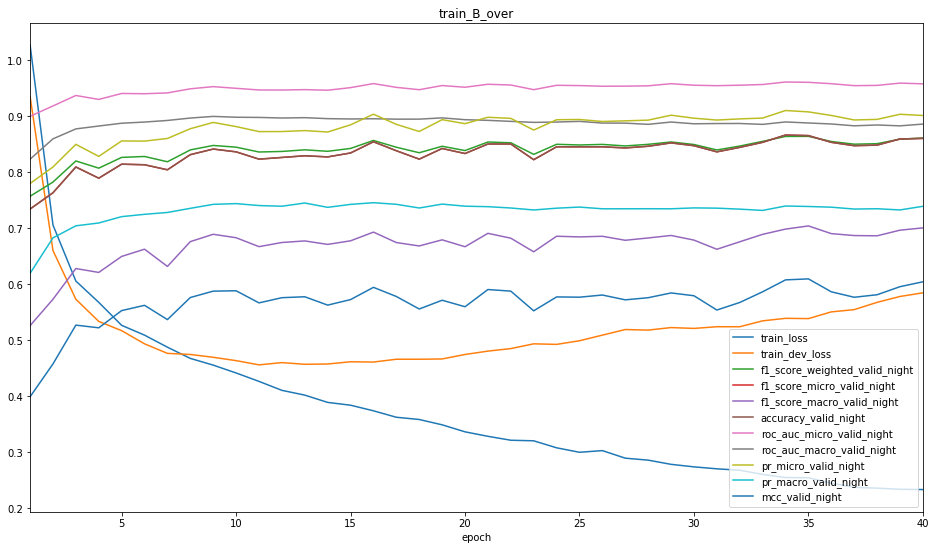

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)